<a href="https://colab.research.google.com/github/NadineML/MAML-Pytorch/blob/master/ProtoNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
* [Setup](#scrollTo=T0ay-ybnOqDn)
* [Configuration](#scrollTo=WKwMFW2Mnf_a&uniqifier=37)
  * **interactive** [mount drive](#scrollTo=g9vZGh5SgFmQ)
  * **interactive** [decide if you want to set parameters manually or load config.json](#scrollTo=UyCwYDbpR7Jv) 
  * **interactive** [set parameters manually, if desired](#scrollTo=UyCwYDbpR7Jv) 

* [Execution for manually set parameters](#scrollTo=y7Tf7K6OyW_i)
* [Execution for automatically set parameters](#scrollTo=Ra1IpSVMOJuW)
* [Tensorboard](#scrollTo=RXU_IrrALgwb)

* [Sources](#scrollTo=HexvGfNtzwfV)



# Setup
Execute this block to continue!
Necessary installs will be performed automatically.

### Imports and Installs

In [ ]:
#@title import necessary modules { form-width: "15%", display-mode: "form" }

import os
import time
import argparse
import collections
from PIL import Image
import csv
import copy
from copy import deepcopy
from pathlib import PurePath
import json
import random
from typing import List, Tuple
import subprocess
import sys


try:
    import torch
except ModuleNotFoundError:
    !pip install torch==1.10.2+cu102 torchvision==0.11.3+cu102 torchaudio===0.10.2+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html
    import torch


from torch import nn, optim
from torch.utils.data import DataLoader,Sampler, Dataset
from torchvision import transforms, datasets


from torchvision.models import resnet18, alexnet, squeezenet1_0, googlenet, densenet161
from tqdm import tqdm


try:
    import matplotlib
except ModuleNotFoundError:
    !pip install matplotlib
    import matplotlib

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from torchvision.utils import make_grid

try:
    import numpy as np
except ModuleNotFoundError:
    !pip install numpy
    import numpy as np

try:
    from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
except ModuleNotFoundError:
    !pip install scikit-learn
    from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

try:
    from tensorboardX import SummaryWriter
except ModuleNotFoundError:
    !pip install tensorboardX
    from tensorboardX import SummaryWriter

import seaborn as sb

### Define constants

In [ ]:
#@title colourscheme faps_colours { form-width: "15%", display-mode: "form" }
faps_green=(151/255, 193/255, 57/255)
faps_dark_green=(93/255,119/255,35/255)
faps_light_green=(205/255, 226/255, 158/255)
faps_light_yellow=(1, 234/255, 147/255)
faps_yellow=(1, 204/255, 0)
faps_dark_yellow=(200/255, 162/255, 0)

faps_colours = ListedColormap(["white", faps_light_yellow, faps_yellow, faps_light_green, faps_green, faps_dark_green])

### Define Classes

In [ ]:
#@title Arguments Class  { form-width: "15%", display-mode: "form" }
class Arguments():
    def __init__(
        self, 
        n_way: int, 
        n_shot: int, 
        n_query: int, 
        n_evaluation_tasks: int, 
        image_size: int, 
        batch_size: int, 
        n_training_episodes: int, 
        n_validation_tasks: int, 
        pretrained_net: str,
        lr: float,
        verbose: int,
        data_path: str = ""
      ):
      
      super(Arguments, self).__init__()
      self.n_way = n_way
      self.n_shot = n_shot
      self.n_query = n_query
      self.n_evaluation_tasks = n_evaluation_tasks
      self.image_size = image_size
      self.batch_size = batch_size
      self.n_training_episodes = n_training_episodes
      self.n_validation_tasks = n_validation_tasks
      self.backbone = pretrained_net
      self.verbose = verbose
      self.lr = lr
      self.data_path = data_path
      
      self.base_performance = 0
      self.epochs = -1
     

In [ ]:
#@title PrototypicalNetworks Class { form-width: "15%", display-mode: "form" }
class PrototypicalNetworks(nn.Module):
    def __init__(self, args, logger_path: str = ""):
        super(PrototypicalNetworks, self).__init__()
        
       
        self.backbone = get_conv_net(args.backbone)

        if logger_path != "":
            self.logger = SummaryWriter(logger_path)
        else: 
            self.logger = SummaryWriter() 
        
        if args.verbose > 0:
            print("Created Prototypical Network model with pretrained {} as a backbone\n".format(
                args.backbone))
        if args.verbose == 2:
            print("\nNetwork architecture: \n{}".format(self.backbone))
            
    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))

        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


In [ ]:
#@title ModDataset { form-width: "15%", display-mode: "form" }

class ModDataset(Dataset):
    """
    put mini-imagenet files as :
    root :
        |- images/*.jpg includes all imgeas
        |- train.csv
        |- val.csv
    NOTICE: meta-learning is different from general supervised learning, especially the concept of batch and set.
    batch: contains several sets
    sets: contains n_way * k_shot for meta-train set, n_way * n_query for meta-test set.
    """

    def __init__(self, root, mode, batchsz, n_way, k_shot, k_query, resize, startidx=0):
        """

        :param root: root path of mini-imagenet
        :param mode: train, val or test
        :param batchsz: batch size of sets, not batch of imgs
        :param n_way:
        :param k_shot:
        :param k_query: num of qeruy imgs per class
        :param resize: resize to
        :param startidx: start to index label from startidx
        """

        self.batchsz = batchsz  # batch of set, not batch of imgs
        self.n_way = n_way  # n-way
        self.k_shot = k_shot  # k-shot
        self.k_query = k_query  # for evaluation
        self.setsz = self.n_way * self.k_shot  # num of samples per set
        self.querysz = self.n_way * self.k_query  # number of samples per set for evaluation
        self.resize = resize  # resize to
        self.startidx = startidx  # index label not from 0, but from startidx
        self._data = {}
        print('shuffle DB :%s, b:%d, %d-way, %d-shot, %d-query, resize:%d' % (
        mode, batchsz, n_way, k_shot, k_query, resize))

        if mode == 'train':
            self.transform = transforms.Compose([lambda x: Image.open(x).convert('RGB'),
                                                 transforms.Resize((self.resize, self.resize)),
                                                 transforms.RandomHorizontalFlip(),
                                                 transforms.RandomRotation(5),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                 ])
        else:
            self.transform = transforms.Compose([lambda x: Image.open(x).convert('RGB'),
                                                 transforms.Resize((self.resize, self.resize)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                 ])

        self.path = os.path.join(root, 'images')  # image path
        csvdata = self.loadCSV(os.path.join(root, mode + '.csv'))  # csv path
        self.data = []
        
        
        self.img2label = {}
        for i, (k, v) in enumerate(csvdata.items()):
            self.data.append(v)  # [[img1, img2, ...], [img111, ...]]
            self.img2label[k] = i + self.startidx  # {class name:label}
        self.cls_num = len(self.data)

        self.create_batch(self.batchsz)

        self.classes = list(self.img2label.keys())
        self.possible_labels = list(self.img2label.values())

    def loadCSV(self, csvf):
        """
        return a dict saving the information of csv
        :param splitFile: csv file name
        :return: {label:[file1, file2 ...]}
        """
        dictLabels = {}
        with open(csvf) as csvfile:
            csvreader = csv.reader(csvfile, delimiter=',')
            next(csvreader, None)  # skip (filename, label)
            for i, row in enumerate(csvreader):
                filename = row[0]
                label = row[1]
                # append filename to current label
                if label in dictLabels.keys():
                    dictLabels[label].append(filename)
                else:
                    dictLabels[label] = [filename]
                
                self._data.update({filename:label})
        return dictLabels

    def create_batch(self, batchsz):
        """
        create batch for meta-learning.
        ×episode× here means batch, and it means how many sets we want to retain.
        :param episodes: batch size
        :return:
        """
        self.support_x_batch = []  # support set batch
        self.query_x_batch = []  # query set batch
        for b in range(batchsz):  # for each batch
            # 1.select n_way classes randomly
            selected_cls = np.random.choice(self.cls_num, self.n_way, False)  # no duplicate
            np.random.shuffle(selected_cls)
            support_x = []
            #query_x = []
            mix_q = [None]*self.n_way
            i = 0
            for cls in selected_cls:
                # 2. select k_shot + k_query for each class
                selected_imgs_idx = np.random.choice(len(self.data[cls]), self.k_shot + self.k_query, False)
                np.random.shuffle(selected_imgs_idx)
                indexDtrain = np.array(selected_imgs_idx[:self.k_shot])  # idx for Dtrain
                indexDtest = np.array(selected_imgs_idx[self.k_shot:])  # idx for Dtest
                support_x.append(
                    np.array(self.data[cls])[indexDtrain].tolist())  # get all images filename for current Dtrain
                
                mix_q[i] = np.array(self.data[cls])[indexDtest].tolist()
                i += 1
            
            # shuffle the correponding relation between support set and query set
            #random.shuffle(support_x)
            random.shuffle(mix_q)
            query_x = [[e] for cl in mix_q for e in cl]
            
            self.support_x_batch.append(support_x)  # append set to current sets
            self.query_x_batch.append(query_x)  # append sets to current sets

    def __getitem__(self, index):
        """
        index means index of sets, 0<= index <= batchsz-1
        :param index:
        :return:
        """
        # [setsz, 3, resize, resize]
        support_x = torch.FloatTensor(self.setsz, 3, self.resize, self.resize)
        # [setsz]
        support_y = np.zeros((self.setsz), dtype=int)
        # [querysz, 3, resize, resize]
        query_x = torch.FloatTensor(self.querysz, 3, self.resize, self.resize)
        # [querysz]
        query_y = np.zeros((self.querysz), dtype=int)

        flatten_support_x = [os.path.join(self.path, item)
                             for sublist in self.support_x_batch[index] for item in sublist]
        support_y = np.array(
            [self.img2label[self._data[item]]  
             for sublist in self.support_x_batch[index] for item in sublist]).astype(int)

        flatten_query_x = [os.path.join(self.path, item)
                           for sublist in self.query_x_batch[index] for item in sublist]
        query_y = np.array([self.img2label[self._data[item]]
                            for sublist in self.query_x_batch[index] for item in sublist]).astype(int)



        unique = np.unique(support_y)
        #random.shuffle(unique)
        # relative means the label ranges from 0 to n-way
        support_y_relative = np.zeros(self.setsz)
        query_y_relative = np.zeros(self.querysz)
        for idx, l in enumerate(unique):
            support_y_relative[support_y == l] = idx
            query_y_relative[query_y == l] = idx

        query_labels = torch.LongTensor(query_y_relative)
        for i, path in enumerate(flatten_support_x):
            support_x[i] = self.transform(path)

        for i, path in enumerate(flatten_query_x):
            query_x[i] = self.transform(path)

        #return support_x, torch.LongTensor(support_y), query_x, torch.LongTensor(query_y)
        return support_x, torch.LongTensor(support_y_relative), query_x, query_labels, unique

    def __len__(self):
        # as we have built up to batchsz of sets, you can sample some small batch size of sets.
        return self.batchsz


### Define functions

In [ ]:
#@title def fix_seed { form-width: "15%", display-mode: "form" }

def fix_seed(seed=222):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)


In [ ]:
#@title local run hack { form-width: "15%", display-mode: "form" }
#@markdown This cell provides wrappers for data access to ensure compatibility between local run times and hosted run times as well as compatibility for different operating systems in regard to their different path seperator chars.
class download_data_from_folder(object):

    def __init__(self,path):
        path_id = path[path.find('id=')+3:]
        self.filename = ""
        self.file_list = self.get_files_in_location(path_id)
        self.unwrap_data(self.file_list)
        
    def get_files_in_location(self,folder_id):
        file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
        return file_list

    def unwrap_data(self,file_list,directory='.'):
        for i, file in enumerate(file_list):
            if file['mimeType'].find('folder') != -1 and file['title'][0] != '.':
                if not os.path.exists(os.path.join(directory, file['title'])) and file['title'][0] != '.':
                    os.makedirs(os.path.join(directory, file['title']))
                
                self.filename = file['title']
                self.unwrap_data(self.get_files_in_location(file['id']), os.path.join(directory, file['title']))
            else:
                if not os.path.exists(os.path.join(directory, file['title'])) and file['title'][0] != '.':
                    downloaded = drive.CreateFile({'id': file['id']})
                    downloaded.GetContentFile(os.path.join(directory, file['title']))
        return None


def find_file_id(fd_name):
    for file1 in file_list:
        if file1['title'] == fd_name:
            return file1['id']

def provide_files(fd_name, save_to_path=False):
    global local
    if os.path.exists(fd_name): # no need to download anything, file exist in local filesystem
        return fd_name
    
    if save_to_path: # file might not exist yet, create all folders in the path and return a path suitable for the executing OS
        a = os.path.sep
        _p = PurePath(fd_name)
        fd_name = a.join(_p.parts)
        fd = os.path.join(wd,fd_name)
        os.makedirs(fd, exist_ok=True)
        return fd

    if not local: # executing online via Colab (linux), bulding correct absolute path from relative path and absolute path of the mounted drive
        a = os.path.sep
        _p = PurePath(fd_name)
        fd_name = a.join(_p.parts)
        return os.path.join(wd,fd_name)

    if local: # executing in local runtime (could be any OS), adjust path and download data from Google Drive API
        _p = PurePath(fd_name)
        if  _p.parts[0] == '':
            _path = _p.parts[1]
        else:
            _path = _p.parts[0]
        fd = os.path.join(wd,_path)
        os.makedirs(fd, exist_ok=True)
        os.chdir(fd)

        cur_id = find_file_id(_path)
        print(_path)
        fd_name = f'https://drive.google.com/open?id={cur_id}'
        f = download_data_from_folder(fd_name)
        os.chdir(cwd)
        a = os.path.sep
        return os.path.join(fd, a.join(_p.parts[1:]))

def clean_up():
    # upload checkpoints and tensorboard files to Google Drive API
    checkpoints1 = sorted(os.listdir(checkpoint_path))
    for upload_file in checkpoints1:
        gfile = drive.CreateFile({'parents': [{'id': '11iuQVc1GxUlzdeFCcInClzG0bocwLclj'}]})
        gfile.SetContentFile(upload_file)

    figures1 = sorted(os.listdir(figure_path))
    for upload_file in figures1:
        gfile = drive.CreateFile({'parents': [{'id': '1Zm8neCImphpEM4cZxiHtbbuzZVfw_gDf'}]})
        gfile.SetContentFile(upload_file)

    tensorboards = sorted(os.listdir(tb_path))
    for upload_file in tensorboards:
        gfile = drive.CreateFile({'parents': [{'id': '12858B1TN0dP3ga0ZQVBLdoRZXGyJnwlf'}]})
        gfile.SetContentFile(upload_file)

def del_drive():
    # clean local file system of downloaded and created files
    global local
    local = False
    if "MyDrive" in cwd:
        for file in os.scandir(provide_files(".")):
            os.remove(file.path)



In [ ]:
#@title def create_subfilesystem  { form-width: "15%", display-mode: "form" }
def create_subfilesystem(b_p, config):
    path_dict = {}
    conf_dict = config.pop("params")
    run_c = 0 #TODO

    for key in config.keys():
        p0 = os.path.join(b_p, "checkpoints")
        os.makedirs(p0, exist_ok=True)
        p01 = os.path.join(b_p, "figures")
        os.makedirs(p01, exist_ok=True)
        p1 = os.path.join(p0, key)
        p11 = os.path.join(p01, key)
        os.makedirs(p1, exist_ok=True)
        os.makedirs(p11, exist_ok=True)

        path_dict.update({key:{}})

        for param_combo in config[key]:

            p2 = os.path.join(p1, f"run {run_c}")
            p21 = os.path.join(p11, f"run {run_c}")
            os.makedirs(p2, exist_ok=True)
            os.makedirs(p21, exist_ok=True)
            path_dict[key].update({f"run {run_c}": f"{key}/run {run_c}"})
            run_c += 1

    return path_dict, conf_dict

In [ ]:
#@title functions to save to *.csv { form-width: "15%", display-mode: "form" }

def save_report_as_csv(save_to_path, report_dict):
  with open(save_to_path, 'w', newline='') as csvfile:

      header_key = ['label','precision','recall','f1-score', 'support']
      new_val = csv.DictWriter(csvfile, dialect='excel', fieldnames=header_key)
      new_val.writeheader()

      for key in report_dict.keys():
          if key != 'accuracy':
            new_val.writerow({'label': key, 'precision': report_dict[key]['precision'], 'recall' : report_dict[key]['recall'],'f1-score' : report_dict[key]['f1-score'], 'support' : report_dict[key]['support']})

  print("Classification report was saved at "+save_to_path+"\n")


In [ ]:
#@title # def fetch_model  { form-width: "15%", display-mode: "form" }
#@markdown This function is used to load model checkpoints
def fetch_model(load_path_checkpoint):

    global args

    model = PrototypicalNetworks(args).to(device)
    checkpoint = torch.load(load_path_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    
    if args.verbose > 0: print("Fetched model {}\n".format(load_path_checkpoint))
    return model, optimizer, checkpoint['epoch']

In [ ]:
#@title #functions to evaluate the model { form-width: "15%", display-mode: "form" }
def evaluate_on_one_task_properly(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
):
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    m = torch.max(
            model(support_images.squeeze().to(device), 
                  support_labels.squeeze().to(device), 
                  query_images.squeeze().to(device))
            .detach()
            .data,
            1,
        )

    rt = (
        m[1]
        == query_labels.to(device)
    )
    c = rt.sum().item()

    t =  len(query_labels[0])
    d =  list(zip(query_labels.cpu().tolist()[0], list(m[1].cpu().tolist())))

    return c, t, d


def evaluate_properly(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    
    total_predictions = 0
    correct_predictions = 0
    total_classifications = []
    
    
    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
       
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total, classifications = evaluate_on_one_task_properly(
                support_images, support_labels, query_images, query_labels
            )
            _y_true_, _y_pred_ = zip(*classifications)

            y_true_ = [class_ids[0][i] for i in list(_y_true_)]
            y_pred_ = [class_ids[0][i] for i in list(_y_pred_)]
            total_predictions += total
            correct_predictions += correct
            total_classifications.extend(zip(y_true_, y_pred_))

    y_true_, y_pred_ = zip(*total_classifications)
    y_true = [i.item() for i in list(y_true_)]
    y_pred = [i.item() for i in list(y_pred_)]
    accuracy = 100 * correct_predictions/total_predictions

    
    model.logger.add_scalar("val/accuracy", correct_predictions/total_predictions, args.epochs)
    if args.verbose == 2:
        print("Ground Truth / Predicted")
        for i in range(total_predictions):
            print(
                #f"{total_classifications[i][0]}/{total_classifications[i][1]}"
                f"{list(faps_data_test.img2label.keys())[y_true[i]]} / {list(faps_data_test.img2label.keys())[y_pred[i]]}"
            )
        print("\n\n")
    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {accuracy:.2f}%"
    )
    
    return y_true, y_pred, accuracy



In [ ]:
#@title # def get_metrics { form-width: "5%", display-mode: "form" }
def get_metrics(data_loader: DataLoader):
    global args

    true_labels, predictions, acc = evaluate_properly(data_loader)

    if args.epochs > -1:
        model.logger.add_scalar("train/accuracy", acc, args.epochs)
  
    if args.verbose > 0:
        fig, ax = plt.subplots(figsize=(20,20))
        labels = list(data_loader
                    .dataset
                    .img2label
                    .values())

        disp = ConfusionMatrixDisplay.from_predictions(
            y_true=true_labels, 
            y_pred=predictions, 
            labels=labels, 
            sample_weight=None, 
            normalize='true', 
            display_labels=list(data_loader.dataset.img2label.keys()), 
            include_values=True, 
            xticks_rotation='vertical', 
            values_format=None, 
            cmap=faps_colours, 
            ax=ax, 
            colorbar=True)
      
        save_to_path = "figures"
        confusion_matrix_filename = "confusion-matrix_n-way_{}_n-shot_{}_n-query_{}_training-epochs_{}_validation-tasks_{}.svg".format(args.n_way, args.n_shot, args.n_query, args.epochs, args.n_validation_tasks)
        plt.savefig(os.path.join(figure_path, confusion_matrix_filename))
        plt.show(disp)
    classification_report_filename =  "classification-report_n-way_{}_n-shot_{}_n-query_{}_training-epochs_{}_validation-tasks_{}.csv".format(args.n_way, args.n_shot, args.n_query, args.epochs, args.n_validation_tasks)
    clrep = classification_report(true_labels, 
                                predictions,
                                labels=labels,
                                target_names=data_loader.dataset.classes, 
                                output_dict=True, 
                                zero_division=0)
    save_report_as_csv(os.path.join(figure_path, classification_report_filename), clrep)

    if args.verbose > 0:
        print("\n\n")
        print(classification_report(true_labels, predictions,labels=data_loader.dataset.possible_labels,target_names=data_loader.dataset.classes, output_dict=False, zero_division=0))
    if args.epochs == -1:
        args.base_performance = acc
    else:
        print("\nModel trained for {} epochs. Accuracy has changed from baseline {:.2f}% to  {:.2f}%.\nThis means improvement by {:.3f}%\n".format(args.epochs, args.base_performance, acc, acc - args.base_performance))
    return clrep

In [ ]:
#@title # def fit { form-width: "15%", display-mode: "form" }
def prepare_training(args):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    return criterion, optimizer

def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.squeeze().to(device), 
        support_labels.squeeze().to(device), 
        query_images.squeeze().to(device)
    )
    
    loss = criterion(classification_scores, query_labels[0].to(device))
    loss.backward()
    optimizer.step()

    return loss.item()


In [ ]:
#@title #def training { form-width: "15%", display-mode: "form" }

def training(model, args, train_data, test_data):
    global criterion
    global optimizer
    
    episode_counter = 0
    log_update_frequency = 5
    save_model_frequency = 5

    offset = max(args.epochs, 0)
    model.train()
    

    for ep in range(args.n_training_episodes):
        print(f"\nRun {run_counter}: Training episode {ep}\n")
        # create DataLoader object for testing
        test_loader = DataLoader(
            test_data,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
        )

        # create DataLoader object for training
        train_loader = DataLoader(
            train_data,
            args.batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
        )

    
        with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
            tqdm_train.n = offset 
            tqdm_train.last_print_n = offset
            tqdm_train.update()
            for episode_index, (
                support_images,
                support_labels,
                query_images,
                query_labels,
                _,
            ) in tqdm_train:
                batch_loss = 0
                if len(query_images.shape) < 5:
                    support_images,  support_labels, query_images, query_labels = support_images.unsqueeze(dim=0),  support_labels.unsqueeze(dim=0), query_images.unsqueeze(dim=0), query_labels.unsqueeze(dim=0)
                b = query_images.shape[0]
                for i in range(b):
                    support_x = support_images[i].unsqueeze(dim=0)
                    support_y = support_labels[i].unsqueeze(dim=0)
                    query_x = query_images[i].unsqueeze(dim=0)
                    query_y = query_labels[i].unsqueeze(dim=0)

                    loss_value = fit(support_x, support_y, query_x, query_y)
                    batch_loss += loss_value
                model.logger.add_scalar("train/loss", batch_loss, episode_counter)
                


                if (episode_index) % log_update_frequency == 0 and episode_index > 0:
                    
                    tqdm_train.set_postfix(loss=loss_value)

                episode_counter += 1
            model.logger.add_scalar("episodes/epoch", episode_counter, args.epochs)

        if args.epochs % 2 == 0:             
            _ = get_metrics(test_loader)
            
                
        if (args.epochs) % save_model_frequency == 0  or args.epochs == (args.n_training_episodes -1):
                        
            torch.save(
                {
                    'epoch': args.epochs,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                }, 
                os.path.join(
                    checkpoint_path,
                    "model-epoch_{:02}-N_way_{}-N_shot_{}-N_query_{}.pt".format(args.epochs, args.n_way, args.n_shot, args.n_query)
                )
            )
            print("\nSaved model!\n")
        args.epochs += 1
                
    return get_metrics(test_loader)

In [ ]:
def get_conv_net(backbone):
    nets = ["resnet18", "alexnet", "squeezenet", "googlenet", "densenet161"]
    
    idx = nets.index(backbone)
    if idx == 0:
        conv_net = resnet18(pretrained=True)
    elif idx == 1:
        conv_net = alexnet(pretrained=True)
    elif idx == 2:
        conv_net = squeezenet1_0(pretrained=True)
    elif idx == 3:
        conv_net = googlenet(pretrained=True)
    elif idx == 4:
        conv_net = densenet161(pretrained=True)
    conv_net.fc = nn.Flatten()

    return conv_net

In [ ]:
#@title the ACTUAL algorithm { form-width: "15%", display-mode: "code" }
def run_for_one_param_setting(save_to_path, args):
    global checkpoint_path
    global figure_path
    global run_counter
    
    checkpoint_path = os.path.join(drive_path, "checkpoints", save_to_path)
    figure_path = os.path.join(drive_path, "figures", save_to_path)


    # create model with backbone
    global model
    model = PrototypicalNetworks(args, os.path.join(tb_path, f"run{run_counter}")).to(device)

    global criterion
    global optimizer
    criterion, optimizer = prepare_training(args)

    # create DataLoader object for testing
    test_loader = DataLoader(
        faps_data_test,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )


    # visualize one task
    if args.verbose > 0:
        (
            example_support_images,
            example_support_labels,
            example_query_images,
            example_query_labels,
            example_class_ids
        ) = next(iter(test_loader))
        print("This task contains the following {} classes {}\n".format(args.n_way, example_class_ids.tolist()[0]))
        #plot_images(example_support_images, "support images", images_per_row=N_SHOT)
        #plot_images(example_query_images, "query images", images_per_row=N_QUERY)

    # establish baseline
    _ = get_metrics(test_loader)

    # train the model and save results
    args.epochs = 0
    cr = training(model, args, faps_data_train, faps_data_test)


    # save info with tensorboard
    
    
    macros = cr['macro avg']
    with SummaryWriter(provide_files(f'{tb_path}/hp', save_to_path=True)) as w:
        w.add_hparams({
            'run': run_counter,
            'N_way': args.n_way,
            'K_shot': args.n_shot,
            'K_query': args.n_query,
            'image_size': args.image_size,
            'lr': args.lr,
            'backbone': args.backbone,
            'epochs_trained': args.epochs
        },
        {
            "hparam/recall": macros["recall"],
            "hparam/F1-score": macros["f1-score"],
            "hparam/precision": macros["precision"]
        })
        w.flush()


# Configuration: Manual input required
Mount Google Drive and set parameters manually or via JSON to get started!

In [ ]:
#@title Mount Google Drive { form-width: "15%", display-mode: "form" }
#@markdown This block requires you to go through the login process of your Google Account to access Google Drive where your dataset should be stored.
from google.colab import drive
base_path = '/content/data'
drive.mount(base_path, force_remount=True)
wd = os.path.join(base_path, "MyDrive")

Mounted at /content/data


In [ ]:
#@title parameter configuration
#@markdown Select this option and provide a config to skip the manual parameter entry of the next cell 
set_parameters_from_config_file = False #@param {type:"boolean"}
#@markdown Please provide a path relative to the "root" level of your Google Drive account including the filename and its filename extension
rel_config_path = "ProtoFAPS/config.json" #@param {type:"string"}

if set_parameters_from_config_file:
    if rel_config_path == "":
        print("Please provide rel_config_path or disable the set_parameters_from_config_file option!")
    config_path = os.path.join(wd, rel_config_path)
    with open(config_path) as json_file:
        config_json = json.load(json_file)

    #p = os.path.join(wd, "PrototypicalNetwork")
    data_path = config_json["params"]["data_path"]
    drive_path = os.path.join(base_path, "MyDrive", data_path)
    path_dict, conf_dict = create_subfilesystem(drive_path, config_json)

    
    tb_path = os.path.join(drive_path, "tensorboards_ProtoNet")
    os.makedirs(tb_path, exist_ok=True)

    preferred_device = conf_dict["preferred_device"]
    if preferred_device == "GPU" and torch.cuda.is_available():
        device = 'cuda'
        gpu_info = !nvidia-smi
        gpu_info = '\n'.join(gpu_info)
        if gpu_info.find('failed') >= 0:
            print('Could not connect to GPU, connected to CPU instead!')
            device = 'cpu'
        else:
            print("Connected to the following GPU:\n")
            print(gpu_info)
    else:
        device='cpu'
    
    image_size = conf_dict["image_size"]
    

In [66]:
#@title configuration pt 2: manually { form-width: "15%", display-mode: "form" }

if not set_parameters_from_config_file:
    #@markdown #### Number of images per class in the support set
    n_shot = 2 #@param {type:"slider", min:1, max:5, step:1}
    #@markdown #### Number of classes in a task
    n_way = 5 #@param {type:"slider", min:1, max:15, step:1}
    #@markdown #### Number of images per class in the query set
    n_query = 1 #@param {type:"slider", min:1, max:5, step:1}
    n_evaluation_tasks = 25 #@param {type:"slider", min:1, max:100, step:1}
    image_size = 256 #@param {type:"slider", min:244, max:512, step:128}
    batch_size = 2 #@param {type:"slider", min:1, max:16, step:1}
    n_training_episodes = 1 #@param {type:"slider", min:1, max:60, step:5}
    n_validation_tasks = 20 #@param {type:"slider", min:5, max:60, step:5}
    LR = 0.0081 #@param {type:"slider", min:0.000001, max:0.01, step:0.00005}
    #@markdown ---
    #@markdown ### Choose if you want to use GPU or CPU:
    preferred_device = "GPU" #@param ["CPU", "GPU"]
    #@markdown ---
    #@markdown ### Enter a Google Drive path to your dataset:
    data_path = "ProtoFAPS" #@param {type:"string"}
    #@markdown ---

    if preferred_device == "GPU" and torch.cuda.is_available():
        device = 'cuda'
        gpu_info = !nvidia-smi
        gpu_info = '\n'.join(gpu_info)
        if gpu_info.find('failed') >= 0:
            print('Could not connect to GPU, connected to CPU instead!')
            device = 'cpu'
        else:
            print("Connected to the following GPU:\n")
            print(gpu_info)
    else:
        device = 'cpu'
        print("Connected to CPU, this might be slow. Consider connecting to GPU and executing this code cell again!\n")

    #@markdown ### Choose a pretrained model to start with:
    pretrained_net = "resnet18" #@param ["resnet18", "alexnet", "squeezenet", "googlenet", "densenet161"]

    #@markdown ---
    #@markdown ### How much output do you want to generate:
    verbose = "moderate output" #@param ["minimal output", "moderate output", "verbose"]
    verbose_levels = ["minimal output", "moderate output", "verbose"]

    run_no =  100#@param {type:"integer"}

    run_counter = run_no
    N_WAY = n_way
    N_SHOT = n_shot
    N_QUERY = n_query
    N_EVALUATION_TASKS = n_evaluation_tasks
    N_TRAINING_EPISODES = n_training_episodes
    N_VALIDATION_TASKS = n_validation_tasks
    VERBOSE = verbose_levels.index(verbose)

    drive_path = os.path.join(base_path, "MyDrive", data_path)
    tb_path = os.path.join(drive_path, "tensorboards_ProtoNet")
    os.makedirs(tb_path, exist_ok=True)
    

    args = Arguments(n_way, n_shot, n_query, n_evaluation_tasks, image_size, batch_size, n_training_episodes, n_validation_tasks, pretrained_net, LR, VERBOSE, data_path)

Connected to the following GPU:

Mon Mar 14 07:59:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    35W / 250W |   2809MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                       

# Run Code
Execute this block after running the Setup block as well as the Configuration block!

In [ ]:
#@title Tensorboard { form-width: "15%", display-mode: "form" }

%load_ext tensorboard 
%tensorboard --logdir "$tb_path"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

shuffle DB :val, b:20, 5-way, 2-shot, 1-query, resize:256
shuffle DB :train, b:20, 5-way, 2-shot, 1-query, resize:256
Created Prototypical Network model with pretrained resnet18 as a backbone

This task contains the following 5 classes [0, 1, 7, 8, 9]



100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Model tested on 20 tasks. Accuracy: 81.00%


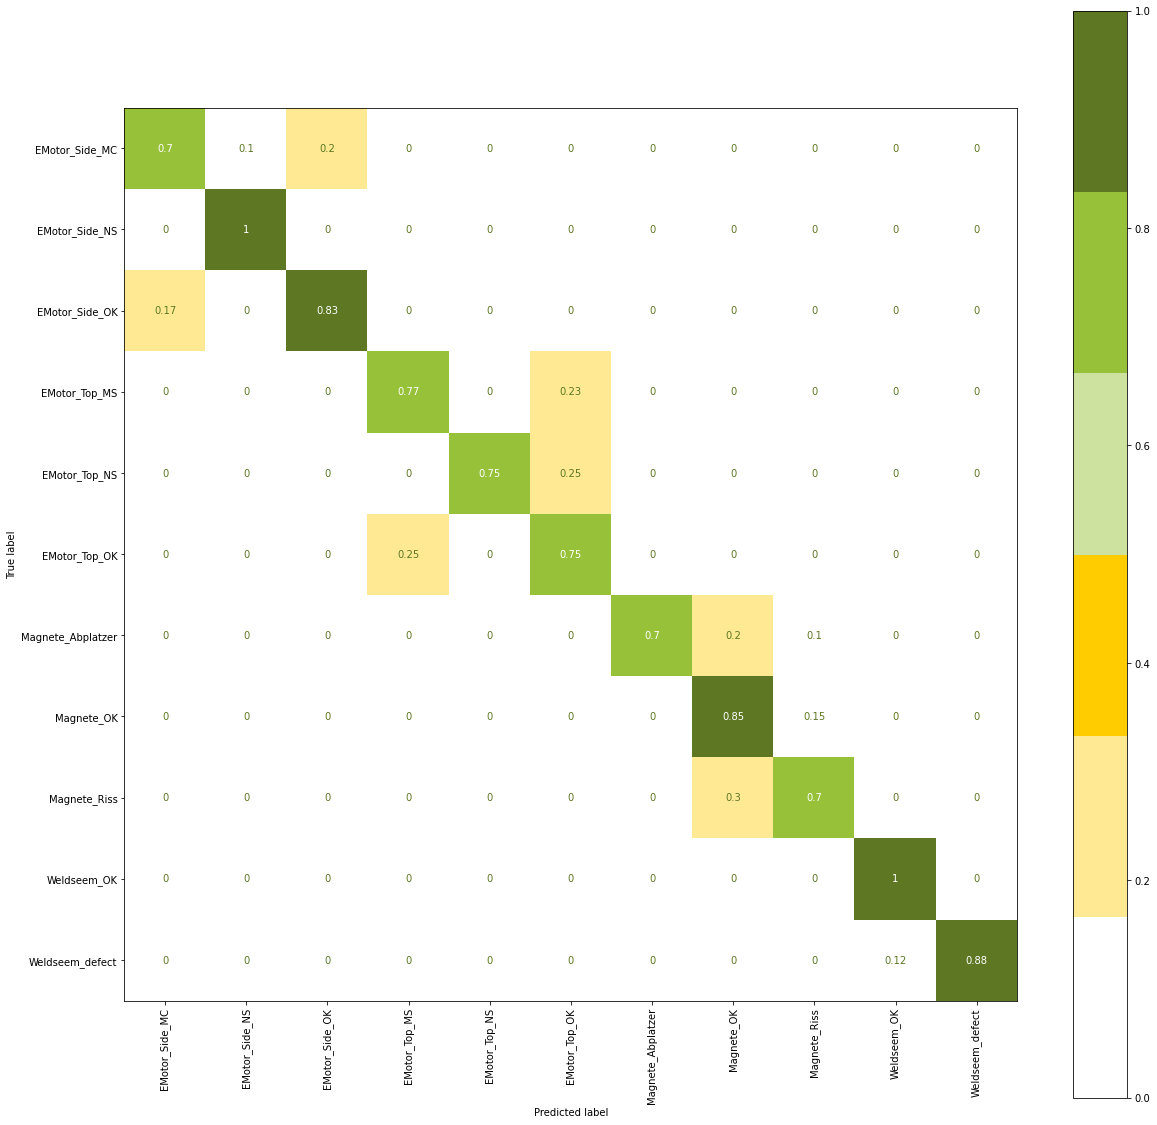

Classification report was saved at /content/data/MyDrive/ProtoFAPS/classification-report_n-way_5_n-shot_2_n-query_1_training-epochs_-1_validation-tasks_20.csv




                   precision    recall  f1-score   support

   EMotor_Side_MC       0.88      0.70      0.78        10
   EMotor_Side_NS       0.86      1.00      0.92         6
   EMotor_Side_OK       0.71      0.83      0.77         6
    EMotor_Top_MS       0.83      0.77      0.80        13
    EMotor_Top_NS       1.00      0.75      0.86         4
    EMotor_Top_OK       0.60      0.75      0.67         8
Magnete_Abplatzer       1.00      0.70      0.82        10
       Magnete_OK       0.69      0.85      0.76        13
     Magnete_Riss       0.70      0.70      0.70        10
      Weldseem_OK       0.92      1.00      0.96        12
  Weldseem_defect       1.00      0.88      0.93         8

         accuracy                           0.81       100
        macro avg       0.84      0.81      0.82       100
     weig

11it [00:26,  2.45s/it, loss=1.52]
100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Model tested on 20 tasks. Accuracy: 65.00%


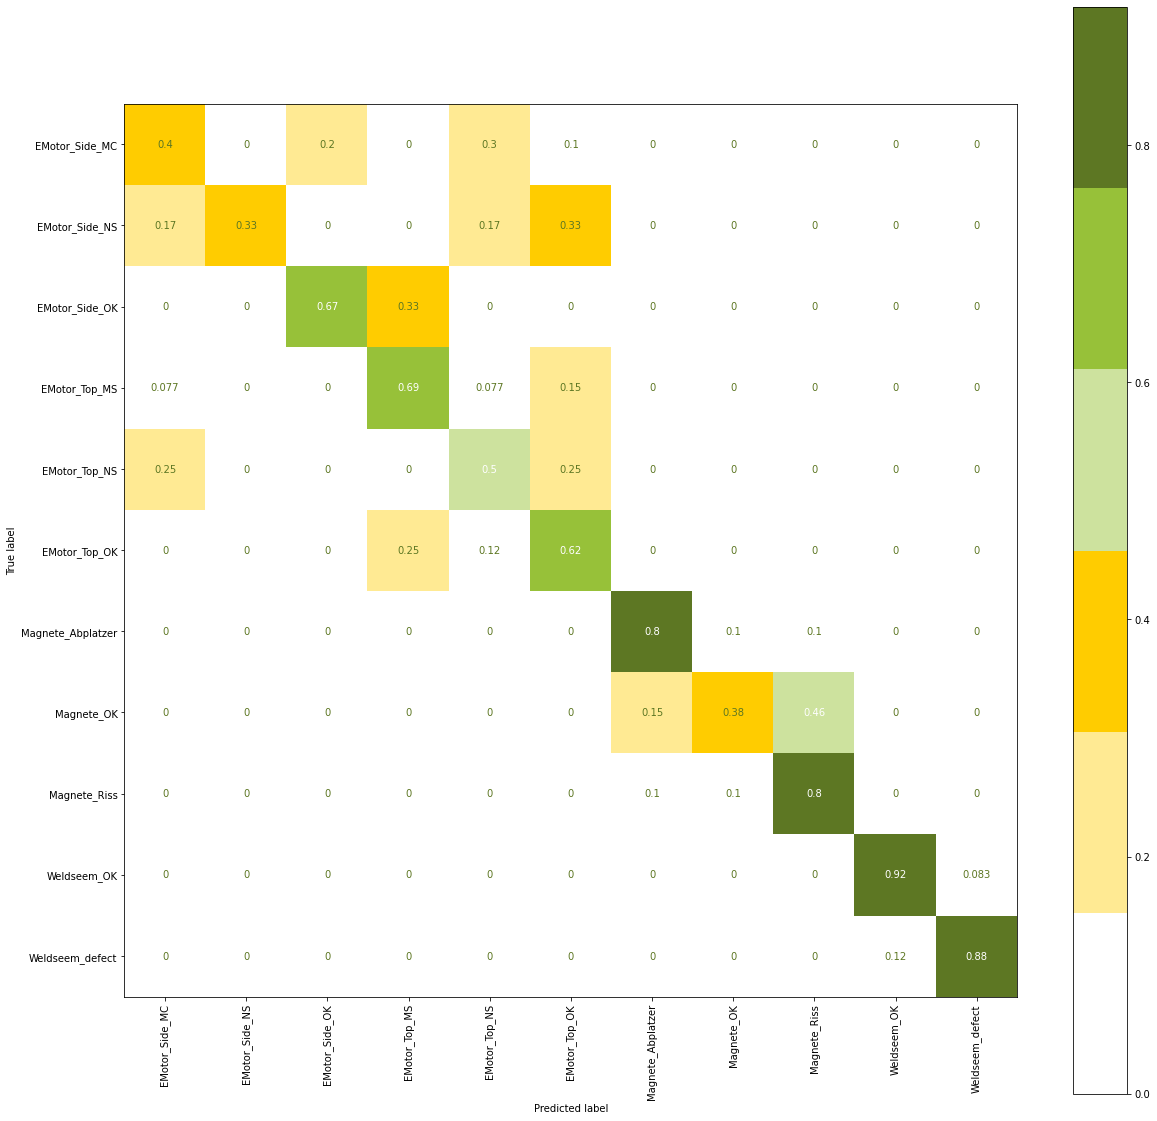

Classification report was saved at /content/data/MyDrive/ProtoFAPS/classification-report_n-way_5_n-shot_2_n-query_1_training-epochs_0_validation-tasks_20.csv




                   precision    recall  f1-score   support

   EMotor_Side_MC       0.57      0.40      0.47        10
   EMotor_Side_NS       1.00      0.33      0.50         6
   EMotor_Side_OK       0.67      0.67      0.67         6
    EMotor_Top_MS       0.69      0.69      0.69        13
    EMotor_Top_NS       0.25      0.50      0.33         4
    EMotor_Top_OK       0.45      0.62      0.53         8
Magnete_Abplatzer       0.73      0.80      0.76        10
       Magnete_OK       0.71      0.38      0.50        13
     Magnete_Riss       0.53      0.80      0.64        10
      Weldseem_OK       0.92      0.92      0.92        12
  Weldseem_defect       0.88      0.88      0.88         8

         accuracy                           0.65       100
        macro avg       0.67      0.64      0.63       100
     weigh

100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Model tested on 20 tasks. Accuracy: 65.00%


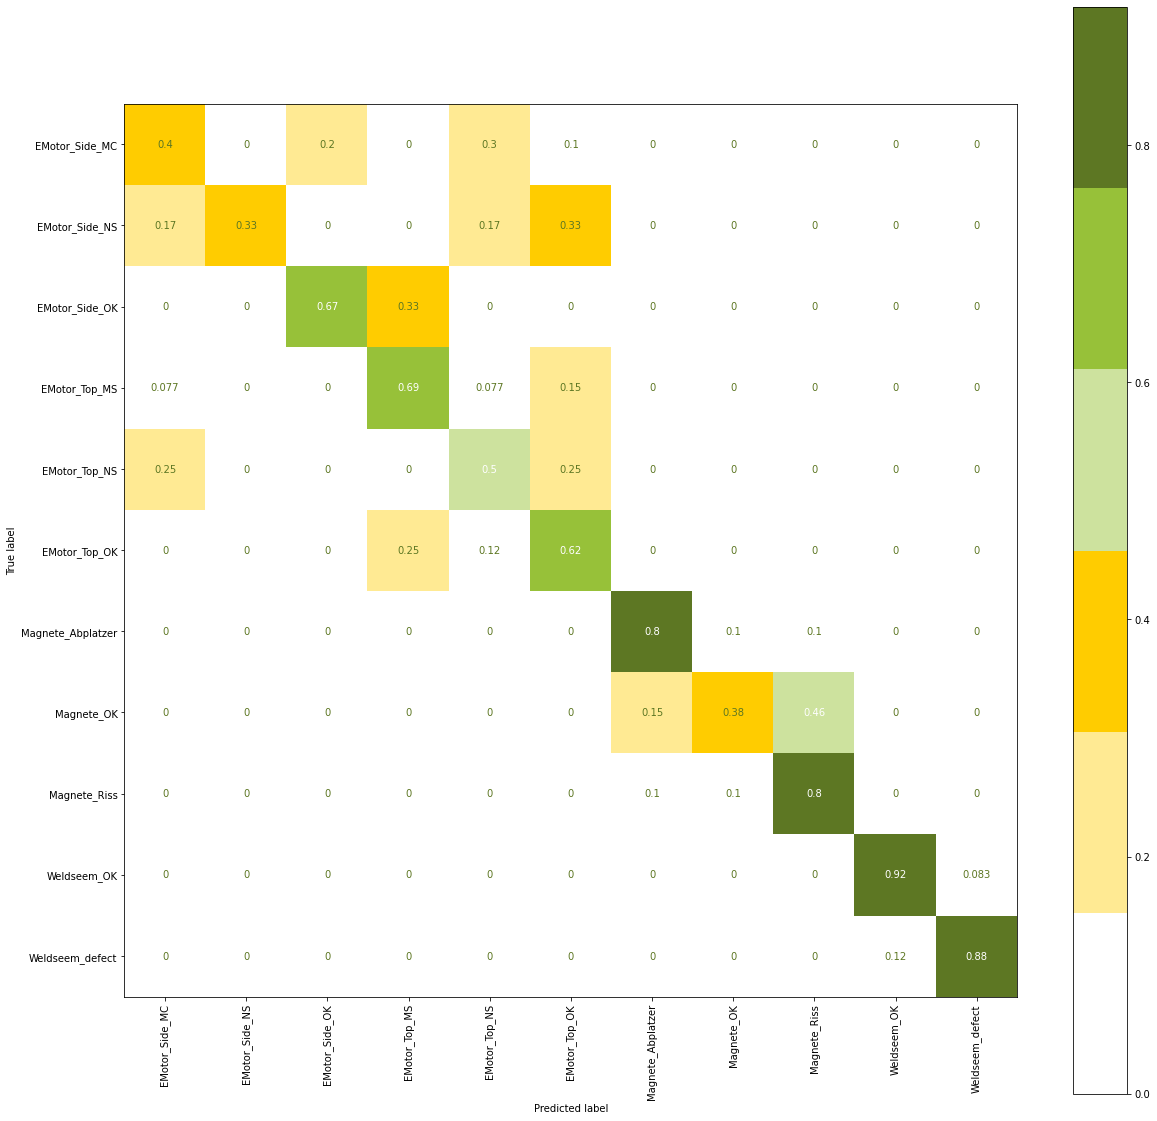

Classification report was saved at /content/data/MyDrive/ProtoFAPS/classification-report_n-way_5_n-shot_2_n-query_1_training-epochs_1_validation-tasks_20.csv




                   precision    recall  f1-score   support

   EMotor_Side_MC       0.57      0.40      0.47        10
   EMotor_Side_NS       1.00      0.33      0.50         6
   EMotor_Side_OK       0.67      0.67      0.67         6
    EMotor_Top_MS       0.69      0.69      0.69        13
    EMotor_Top_NS       0.25      0.50      0.33         4
    EMotor_Top_OK       0.45      0.62      0.53         8
Magnete_Abplatzer       0.73      0.80      0.76        10
       Magnete_OK       0.71      0.38      0.50        13
     Magnete_Riss       0.53      0.80      0.64        10
      Weldseem_OK       0.92      0.92      0.92        12
  Weldseem_defect       0.88      0.88      0.88         8

         accuracy                           0.65       100
        macro avg       0.67      0.64      0.63       100
     weigh

In [68]:
#@title RUN manually  { form-width: "15%", display-mode: "form" }
if not set_parameters_from_config_file:
    fix_seed()
    args = Arguments(
        n_way = N_WAY, 
        n_shot = N_SHOT, 
        n_query = N_QUERY,
        n_evaluation_tasks = N_EVALUATION_TASKS,
        image_size = image_size,
        batch_size = batch_size,
        n_training_episodes = n_training_episodes,
        n_validation_tasks = N_VALIDATION_TASKS,
        pretrained_net = pretrained_net,
        lr = LR,
        verbose = VERBOSE,
        data_path = drive_path
      )

    faps_data_test = ModDataset(drive_path, mode='val', n_way=args.n_way, k_shot=args.n_shot,
            k_query=args.n_query,
            batchsz=args.n_validation_tasks, resize=args.image_size)

    faps_data_train = ModDataset(drive_path, mode='train', n_way=args.n_way, k_shot=args.n_shot,
            k_query=args.n_query,
            batchsz=args.n_validation_tasks, resize=args.image_size)

    
    foldername = "{}-n_way_{}-n_shot_{}-n_query-{}".format(pretrained_net, N_WAY, N_SHOT, N_QUERY)
    p1 = drive_path
    figure_path = os.path.join(p1, "figures")
    checkpoint_path = os.path.join(p1, "checkpoints")

    os.makedirs(p1, exist_ok=True)
    os.makedirs(figure_path, exist_ok=True)
    os.makedirs(checkpoint_path, exist_ok=True)
    
    run_for_one_param_setting(p1, args)



In [ ]:
#@title RUN automatically  { form-width: "15%", display-mode: "form" }
run_counter = 0
if set_parameters_from_config_file:
    for key in config_json.keys():
        if key == "densenet161":
            run_counter = 48
        for param in config_json[key]:
            fix_seed()
            args = Arguments(
                n_way = param["n_way"], 
                n_shot = param["n_shot"],
                n_query = param["n_query"],
                n_evaluation_tasks = param["n_evaluation_tasks"],
                image_size = image_size,
                batch_size = param["batch_size"],
                n_training_episodes = param["n_training_episodes"],
                n_validation_tasks = param["n_validation_tasks"],
                pretrained_net = param["pretrained_net"],
                lr = param["lr"],
                verbose = param["verbose"],
                data_path = drive_path
            )

            faps_data_test = ModDataset(drive_path, mode='val', n_way=args.n_way, k_shot=args.n_shot,
                    k_query=args.n_query,
                    batchsz=args.n_validation_tasks, resize=args.image_size)

            faps_data_train = ModDataset(drive_path, mode='train', n_way=args.n_way, k_shot=args.n_shot,
                    k_query=args.n_query,
                    batchsz=args.n_validation_tasks, resize=args.image_size)

            run_for_one_param_setting(path_dict[key][f"run {run_counter}"], args)
            run_counter += 1

# generate images for performance metrics (optional)

In [ ]:
#@title generate confusion matrix / heatmaps functions { form-width: "5%", display-mode: "form" }
def generate_bin_figures(d_path, args, maml):
    val_dt = ModDataset(d_path, mode='val', batchsz=25, n_way=args.n_way, k_shot=args.k_spt, k_query=args.k_qry, resize=args.image_size)
    test_loader = DataLoader(
        val_dt,
        args.batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )
    args.n_validation_tasks = (150 // args.n_way)
    cur_step = 0
    true_labels, predictions, acc = evaluate_properly(test_loader)
    

    _truth = true_labels
    _prediction = predictions

    sfp = os.path.join(figure_path, "bin_conf+report")
    os.makedirs(sfp, exist_ok=True)

    l = list(range(len(val_dt.img2label.keys())))
    truth, _ = binarize_classes(_truth, list(val_dt.img2label.keys()))
    prediction, _ = binarize_classes(_prediction, list(val_dt.img2label.keys()))
    _labels, disp_labels = binarize_classes(l, list(val_dt.img2label.keys()))
    print(truth)
    fig, ax = plt.subplots(figsize=(20,20))
    disp = ConfusionMatrixDisplay.from_predictions(y_true=truth, y_pred=prediction, labels=range(len(disp_labels)), sample_weight=None, normalize='true', display_labels=disp_labels, include_values=True, xticks_rotation='vertical', values_format=None, cmap=faps_colours, ax=ax, colorbar=True)

    #save matrix
    norm_confusion_matrix_filename = "BIN_norm_confusion-matrix_run_{:02}-N_way_{}-N_shot_{}-N_query_{}-LR_{:03}.svg".format(run_counter, args.n_way, args.n_shot, args.k_qry, args.lr)
    plt.savefig(os.path.join(sfp, norm_confusion_matrix_filename))
    plt.show(disp)

    classification_report_filename =  "BIN_classification-report_run_{:02}-N_way_{}-N_shot_{}-N_query_{}-LR_{:03}".format(run_counter, args.n_way, args.n_shot, args.k_qry, args.lr)
    class_rep = classification_report(truth, prediction, labels=range(len(disp_labels)), target_names=disp_labels, output_dict=True, zero_division=0)
    save_report_as_csv(os.path.join(sfp, classification_report_filename + '.csv'), class_rep)

    #print(classification_report(truth, prediction, labels=range(len(val_dt.img2label)), target_names=val_dt.img2label.keys(), output_dict=False, zero_division=0))
  
    return class_rep['macro avg']

def generate_figures(d_path, args, maml):
    val_dt = ModDataset(d_path, mode='val', batchsz=30, n_way=args.n_way, k_shot=args.k_spt, k_query=args.k_qry, resize=args.image_size)
    test_loader = DataLoader(
        val_dt,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )
    args.n_validation_tasks = (150 // args.n_way)
    cur_step = 0
    true_labels, predictions, acc = evaluate_properly(test_loader)
    

    truth = true_labels
    prediction = predictions

    fig, ax = plt.subplots(figsize=(20,20))
    disp = ConfusionMatrixDisplay.from_predictions(y_true=truth, y_pred=prediction, labels=range(len(val_dt.img2label.keys())), sample_weight=None, normalize='true', display_labels=list(val_dt.img2label.keys()), include_values=True, xticks_rotation='vertical', values_format=None, cmap=faps_colours, ax=ax, colorbar=True)

    sfp = os.path.join(figure_path, "reg_conf+report")
    os.makedirs(sfp, exist_ok=True)

    #save matrix
    norm_confusion_matrix_filename = "norm_confusion-matrix_run_{:02}-N_way_{}-N_shot_{}-N_query_{}-LR_{:03}.svg".format(run_counter, args.n_way, args.n_shot, args.k_qry, args.lr)
    plt.savefig(os.path.join(sfp, norm_confusion_matrix_filename))
    plt.show(disp)

    classification_report_filename =  "classification-report_run_{:02}-N_way_{}-N_shot_{}-N_query_{}-LR_{:03}".format(run_counter, args.n_way, args.n_shot, args.k_qry, args.lr)
    class_rep = classification_report(truth, prediction, labels=range(len(val_dt.img2label)), target_names=val_dt.img2label.keys(), output_dict=True, zero_division=0)
    save_report_as_csv(os.path.join(sfp, classification_report_filename + '.csv'), class_rep)

    #print(classification_report(truth, prediction, labels=range(len(val_dt.img2label)), target_names=val_dt.img2label.keys(), output_dict=False, zero_division=0))
  
    return class_rep['macro avg']


def create_heatmap(f_data, model_key, res_type):

    sfp = os.path.join(figure_path, "heatmaps")
    os.makedirs(sfp, exist_ok=True)

    fig, ax = plt.subplots(figsize=(11, 9))# plot heatmap
    sb.heatmap(f_data, annot=True, fmt=".2f", cmap=faps_colours, vmin= 0, vmax=1.0,
            linewidth=0.3, cbar_kws={"shrink": .8})



    yticks_labels = [2, 3, 4, 5]
    xticks_labels = [1, 2, 3, 4, 5]
    plt.yticks(np.arange(4) + .5, labels=yticks_labels)
    plt.xticks(np.arange(5) + .5, labels=xticks_labels)

    plt.xlabel('k_spt')
    plt.ylabel('n_way')# title
    title = f'n_way and k_spt combinations for evaluation: {res_type}\n'.upper()
    plt.title(title, loc='center')

    heatmap_filename = "{}_heatmap_{}.svg".format(res_type, model_key)
    plt.savefig(os.path.join(sfp, heatmap_filename))

    plt.show()

def generate_reg_and_bin_figures(d_path, args, maml, seed):
    val_dt = ModDataset(d_path, mode='val', batchsz=25, n_way=args.n_way, k_shot=args.k_spt, k_query=args.k_qry, resize=args.image_size)
    test_loader = DataLoader(
        val_dt,
        args.batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )
    args.n_validation_tasks = (150 // args.n_way)
    cur_step = 0
    true_labels, predictions, acc = evaluate_properly(test_loader)
    

    truth = true_labels
    prediction = predictions


    fig, ax = plt.subplots(figsize=(20,20))
    disp = ConfusionMatrixDisplay.from_predictions(y_true=truth, y_pred=prediction, labels=range(len(val_dt.img2label.keys())), sample_weight=None, normalize='true', display_labels=list(val_dt.img2label.keys()), include_values=True, xticks_rotation='vertical', values_format=None, cmap=faps_colours, ax=ax, colorbar=True)

    sf = os.path.join(figure_path, "reg_conf+report")
    os.makedirs(sf, exist_ok=True)
    sfs = os.path.join(sf, f"seed {seed}")
    os.makedirs(sfs, exist_ok=True)
    sfp = os.path.join(sfs, f"model {run_counter}")
    os.makedirs(sfp, exist_ok=True)


    #save matrix
    norm_confusion_matrix_filename = "norm_confusion-matrix_run_{:02}-N_way_{}-N_shot_{}-N_query_{}-LR_{:03}".format(run_counter, args.n_way, args.n_shot, args.k_qry, args.lr)
    plt.savefig(os.path.join(sfp, norm_confusion_matrix_filename))
    plt.show(disp)

    classification_report_filename =  "classification-report_run_{:02}-N_way_{}-N_shot_{}-N_query_{}-LR_{:03}".format(run_counter, args.n_way, args.n_shot, args.k_qry, args.lr)
    class_rep = classification_report(truth, prediction, labels=range(len(val_dt.img2label)), target_names=val_dt.img2label.keys(), output_dict=True, zero_division=0)
    save_report_as_csv(os.path.join(sfp, classification_report_filename + '.csv'), class_rep)

    # ------ binary  classification below --------

    _truth = true_labels
    _prediction = predictions

    sf2 = os.path.join(figure_path, "bin_conf+report")
    os.makedirs(sf2, exist_ok=True)
    sfs2 = os.path.join(sf2, f"seed {seed}")
    os.makedirs(sfs2, exist_ok=True)
    sfp2 = os.path.join(sfs2, f"model {run_counter}")
    os.makedirs(sfp2, exist_ok=True)


    l = list(range(len(val_dt.img2label.keys())))

    b_truth, _ = binarize_classes(_truth, list(val_dt.img2label.keys()))
    b_prediction, _ = binarize_classes(_prediction, list(val_dt.img2label.keys()))
    _labels, disp_labels = binarize_classes(l, list(val_dt.img2label.keys()))

    fig, ax = plt.subplots(figsize=(20,20))
    disp_b = ConfusionMatrixDisplay.from_predictions(y_true=b_truth, y_pred=b_prediction, labels=range(len(disp_labels)), sample_weight=None, normalize='true', display_labels=disp_labels, include_values=True, xticks_rotation='vertical', values_format=None, cmap=faps_colours, ax=ax, colorbar=True)

    #save matrix
    b_norm_confusion_matrix_filename = "BIN_norm_confusion-matrix_run_{:02}-N_way_{}-N_shot_{}-N_query_{}-LR_{:03}".format(run_counter, args.n_way, args.n_shot, args.k_qry, args.lr)
    plt.savefig(os.path.join(sfp2, b_norm_confusion_matrix_filename))
    plt.show(disp_b)

    b_classification_report_filename =  "BIN_classification-report_run_{:02}-N_way_{}-N_shot_{}-N_query_{}-LR_{:03}".format(run_counter, args.n_way, args.n_shot, args.k_qry, args.lr)
    class_rep_bin = classification_report(b_truth, b_prediction, labels=range(len(disp_labels)), target_names=disp_labels, output_dict=True, zero_division=0)
    save_report_as_csv(os.path.join(sfp2, b_classification_report_filename + '.csv'), class_rep_bin)

 

  
    return class_rep['macro avg'], class_rep_bin['macro avg']


def binarize_classes(class_list, label_list):
    bin_class_list = []
    bin_label_class_list = []
    c1 = 0
    c2 = "_"
    old_iO_labels = ["EMotor_Side_OK", "EMotor_Top_OK", "Magnete_OK", "Weldseem_OK"]
    niO_labels1 = ["EMotor_Side_MC", "EMotor_Side_NS"]
    niO_labels2 = ["EMotor_Top_MS", "EMotor_Top_NS"]
    niO_labels3 = ["Magnete_Riss", "Magnete_Abplatzer"]

    niO1 = [label_list.index(i) for i in niO_labels1]
    iO1 = label_list.index(old_iO_labels[0])
    iO2 = label_list.index(old_iO_labels[1])
    iO3 = label_list.index(old_iO_labels[2])
    iO4 = label_list.index(old_iO_labels[3])
    niO2 = [label_list.index(i) for i in niO_labels2]
    niO3 = [label_list.index(i) for i in niO_labels3]
    niO4 = label_list.index("Weldseem_defect")

    for i in class_list:
        if i == iO1 or i == old_iO_labels[0]:
            c1 = 0
            c2 = "EMotor_Side_iO"
        elif i == iO2 or i == old_iO_labels[1]:
            c1 = 2
            c2 = "EMotor_Top_iO"

        elif i == iO3 or i == old_iO_labels[2]:
            c1 = 4
            c2 = "Magnete_iO"
        
        elif i == iO4 or i == old_iO_labels[3]:
            c1 = 6
            c2 = "Weldseem_iO"
        
        elif i in niO1 or i in niO_labels1:
            c1 = 1
            c2 = "EMotor_Side_niO"

        elif i in niO2 or i in niO_labels2:
            c1 = 3
            c2 = "EMotor_Top_niO"
        
        elif i in niO3 or i in niO_labels3:
            c1 = 5
            c2 = "Magnete_niO"
        
        elif i == niO4 or i == "Weldseem_defect":
            c1 = 7
            c2 = "Weldseem_niO"
        
        bin_class_list.append(c1)
        bin_label_class_list.append(c2)

    return bin_class_list, np.unique(bin_label_class_list)

In [ ]:
#@title loaded latest model of each run in the checkpoints directory and validated them { form-width: "15%", display-mode: "form" }
#@markdown The lastest model of every run will be loaded and saved in **model[#run]**
checkpoint_path = os.path.join(drive_path, "checkpoints")
run_folders = sorted(os.listdir(checkpoint_path))
possible_nets = ["resnet18", "alexnet", "googlenet", "squeezenet", "densenet161"]
run_list = [int(i[4:]) for i in run_folders]
net_list = []
for i in run_folders:
    if len(i)>5:
        k = max(int(i[4]), 0)
    else:
        k = 0
    net_list.append(possible_nets[k])

model_list = [None]*len(run_folders)
c_epochs = [None]*len(run_folders)

for i, r in enumerate(run_folders):
    args.backbone = net_list[i]
    _lr = os.path.join(checkpoint_path, r)
    last_run = sorted(os.listdir(_lr))[-1]
    m, m.optim , epochs = fetch_model(os.path.join(_lr, last_run))
    model_list[i] = m.cpu()
    c_epochs[i] = epochs
    relaunch = True

print(f"Loaded {len(model_list)} different runs to the list model, use the run as index to access corresponding model")

all_res = {}
res = {}
d_path = drive_path

figure_path = os.path.join(drive_path, "figures")

for i, model in enumerate(model_list):
    run_counter = run_list[i]
    print(f"Running model {run_counter}\n")
    model.to(device)

    cur_step = 0
    cur_epoch = 15

    for _n in range(2,6):
        for _k in range(1,6):
            fix_seed()
            print(f"Testing combo {_n}/{_k}/{1}\n")
            args.n_way = _n
            args.k_spt = _k
            args.k_qry = 1

            r = generate_figures(d_path, args, model)
            res.update({f"n-way={_n}, k-spt={_k}, k-qry={1}":r})

    all_res.update({f"model {run_counter}":deepcopy(res)})

meta_res = {}
res_array = np.zeros((4,5))
for model_key in all_res.keys():
    res_array[0] = [all_res[model_key]['n-way=2, k-spt=1, k-qry=1']['f1-score'], all_res[model_key]['n-way=2, k-spt=2, k-qry=1']['f1-score'], all_res[model_key]['n-way=2, k-spt=3, k-qry=1']['f1-score'], all_res[model_key]['n-way=2, k-spt=4, k-qry=1']['f1-score'], all_res[model_key]['n-way=2, k-spt=5, k-qry=1']['f1-score']]
    res_array[1] = [all_res[model_key]['n-way=3, k-spt=1, k-qry=1']['f1-score'], all_res[model_key]['n-way=3, k-spt=2, k-qry=1']['f1-score'], all_res[model_key]['n-way=3, k-spt=3, k-qry=1']['f1-score'], all_res[model_key]['n-way=3, k-spt=4, k-qry=1']['f1-score'], all_res[model_key]['n-way=3, k-spt=5, k-qry=1']['f1-score']]
    res_array[2] = [all_res[model_key]['n-way=4, k-spt=1, k-qry=1']['f1-score'], all_res[model_key]['n-way=4, k-spt=2, k-qry=1']['f1-score'], all_res[model_key]['n-way=4, k-spt=3, k-qry=1']['f1-score'], all_res[model_key]['n-way=4, k-spt=4, k-qry=1']['f1-score'], all_res[model_key]['n-way=4, k-spt=5, k-qry=1']['f1-score']]
    res_array[3] = [all_res[model_key]['n-way=5, k-spt=1, k-qry=1']['f1-score'], all_res[model_key]['n-way=5, k-spt=2, k-qry=1']['f1-score'], all_res[model_key]['n-way=5, k-spt=3, k-qry=1']['f1-score'], all_res[model_key]['n-way=5, k-spt=4, k-qry=1']['f1-score'], all_res[model_key]['n-way=5, k-spt=5, k-qry=1']['f1-score']]
    meta_res.update({model_key:deepcopy(res_array)})
print(meta_res)

meta_res_R = {}
res_array = np.zeros((4,5))
for model_key in all_res.keys():
    res_array[0] = [all_res[model_key]['n-way=2, k-spt=1, k-qry=1']['recall'], all_res[model_key]['n-way=2, k-spt=2, k-qry=1']['recall'], all_res[model_key]['n-way=2, k-spt=3, k-qry=1']['recall'], all_res[model_key]['n-way=2, k-spt=4, k-qry=1']['recall'], all_res[model_key]['n-way=2, k-spt=5, k-qry=1']['recall']]
    res_array[1] = [all_res[model_key]['n-way=3, k-spt=1, k-qry=1']['recall'], all_res[model_key]['n-way=3, k-spt=2, k-qry=1']['recall'], all_res[model_key]['n-way=3, k-spt=3, k-qry=1']['recall'], all_res[model_key]['n-way=3, k-spt=4, k-qry=1']['recall'], all_res[model_key]['n-way=3, k-spt=5, k-qry=1']['recall']]
    res_array[2] = [all_res[model_key]['n-way=4, k-spt=1, k-qry=1']['recall'], all_res[model_key]['n-way=4, k-spt=2, k-qry=1']['recall'], all_res[model_key]['n-way=4, k-spt=3, k-qry=1']['recall'], all_res[model_key]['n-way=4, k-spt=4, k-qry=1']['recall'], all_res[model_key]['n-way=4, k-spt=5, k-qry=1']['recall']]
    res_array[3] = [all_res[model_key]['n-way=5, k-spt=1, k-qry=1']['recall'], all_res[model_key]['n-way=5, k-spt=2, k-qry=1']['recall'], all_res[model_key]['n-way=5, k-spt=3, k-qry=1']['recall'], all_res[model_key]['n-way=5, k-spt=4, k-qry=1']['recall'], all_res[model_key]['n-way=5, k-spt=5, k-qry=1']['recall']]
    meta_res_R.update({model_key:deepcopy(res_array)})
print(meta_res_R)

sfp = os.path.join(figure_path, "recall_heatmaps")
os.makedirs(sfp, exist_ok=True)

for model_key in meta_res_R.keys():
    f_data = meta_res_R[model_key]
    fig, ax = plt.subplots(figsize=(11, 9))# plot heatmap
    sb.heatmap(f_data, annot=True, fmt=".2f", cmap=faps_colours, vmin= 0, vmax=1.0,
            linewidth=0.3, cbar_kws={"shrink": .8})


    yticks_labels = [2, 3, 4, 5]
    xticks_labels = [1, 2, 3, 4, 5]
    plt.yticks(np.arange(4) + .5, labels=yticks_labels)
    plt.xticks(np.arange(5) + .5, labels=xticks_labels)

    plt.xlabel('k_spt')
    plt.ylabel('n_way')# title
    title = 'n_way and k_spt combinations for evaluation: Recall\n'.upper()
    plt.title(title, loc='center')

    heatmap_filename = "recall_heatmap_{}-epoch_{:03}.svg".format(model_key, cur_epoch-1)
    plt.savefig(os.path.join(sfp, heatmap_filename))

    plt.show()

res_array = np.zeros((4,5))

for model_arr in  meta_res_R:
    res_array = np.add(res_array, meta_res_R[model_arr])

res_array /= 5


fig, ax = plt.subplots(figsize=(11, 9))# plot heatmap
sb.heatmap(res_array, annot=True, fmt=".2f", cmap=faps_colours, vmin= 0, vmax=1.0,
        linewidth=0.3, cbar_kws={"shrink": .8})


yticks_labels = [2, 3, 4, 5]
xticks_labels = [1, 2, 3, 4, 5]
plt.yticks(np.arange(4) + .5, labels=yticks_labels)
plt.xticks(np.arange(5) + .5, labels=xticks_labels)

plt.xlabel('k_spt')
plt.ylabel('n_way')# title
title = 'n_way and k_spt combinations for evaluation: Recall\n'.upper()
plt.title(title, loc='center')

heatmap_filename = "AVG__recall_heatmap.svg"
plt.savefig(os.path.join(sfp, heatmap_filename))

plt.show()

# generate Config.json (optional)


In [ ]:
def insert_filesystem_params(json_data):
    params = {
        "data_path": "ProtoFAPS",
        "preferred_device": "GPU",
        "image_size": 256
    }
    json_data["params"] = params
    return json_data   

In [ ]:
def insert_net_params(json_data):
    pretrained_net = ["resnet18", "alexnet", "googlenet", "squeezenet", "densenet161"]
    nr_runs_per_net = 10
    
    for net in pretrained_net:
        params = []
        for _ in range(nr_runs_per_net):
            run = get_run_params(net)
            params.append(run)
        
        json_data[net] = params
            
    return json_data

def get_run_params(net):
    learning_rate = [1E-5, 1E-4, 1E-3, 1E-2]
    n_shot = [1, 2, 3, 4, 5]
    n_way = [2, 3, 4, 5,]
    batch_size = [1, 2, 3, 4]
    
    n_query = 1
    n_evaluation_tasks = 30
    n_training_episodes = 15
    n_validation_tasks = 15
    verbose = 1
    
    run = {}
    run["n_way"] = random.choice(n_way)
    run["n_shot"] = random.choice(n_shot)
    run["lr"] = random.choice(learning_rate)
    
    run["batch_size"] = random.choice(batch_size)
    #run["n_way"] = random.choice(n_way)
    #run["n_way"] = random.choice(n_way)
    
    run["n_evaluation_tasks"] = n_evaluation_tasks
    run["n_query"] = n_query
    run["n_training_episodes"] = n_training_episodes
    run["n_validation_tasks"] = n_validation_tasks
    run["pretrained_net"] = net
    run["verbose"] = verbose
    return run


In [ ]:
    file_name = "config.json"
    save_path = os.path.join(drive_path, file_name)
    fix_seed()
    json_data = {}
    json_data = insert_filesystem_params(json_data)
    json_data = insert_net_params(json_data)
    
    with open(save_path, "w+") as outfile:
        json.dump(json_data, outfile)

# Sources

Code skeleton taken from [here](https://github.com/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb)

Some inspiration found [here](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial16/Meta_Learning.html)
